## Welcome to the learning notebook with cats!

Imports

In [32]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as opt
import matplotlib.pyplot as plt
import numpy as np
from torchvision import datasets
from torchvision.transforms import Compose, Normalize, ToTensor
from torch.utils.data import Subset
from torchmetrics import Accuracy as VAccuracy
from sklearn.model_selection import train_test_split
from tqdm.auto import tqdm

from ignite.engine import create_supervised_evaluator, create_supervised_trainer, Events
from ignite.metrics import Accuracy, Loss
from ignite.utils import setup_logger

Dataset preparations


We get mean and std for normalization

In [49]:
def get_mean_and_std(dataloader):
    channels_sum, channels_squared_sum, num_batches = 0, 0, 0
    for data, _ in dataloader:
        channels_sum += torch.mean(data, dim=[0, 2, 3])
        channels_squared_sum += torch.mean(data ** 2, dim=[0, 2, 3])
        num_batches += 1

    mean = channels_sum / num_batches

    std = (channels_squared_sum / num_batches - mean ** 2) ** 0.5

    return mean, std

In [50]:
transform = Compose(
    [ToTensor()]
)
dataset = torch.utils.data.DataLoader(datasets.ImageFolder('Cats', transform=transform), batch_size=64, shuffle=False)

In [51]:
mean, std = get_mean_and_std(dataset)
print(mean, std)

tensor([0.3851, 0.3576, 0.3296]) tensor([0.2769, 0.2711, 0.2644])


Now we can use it to normalize the resulting dataset

In [81]:
transform = Compose(
    [
        ToTensor(),
        Normalize((0.3851, 0.3576, 0.3296), (0.2769, 0.2711, 0.2644))
    ]
)

dataset = datasets.ImageFolder('Cats', transform=transform)

In [82]:
def train_val_dataset(dataset, val_split=0.25):
    '''Create train and validation datasets'''
    train_idx, val_idx = train_test_split(list(range(len(dataset))), test_size=val_split)
    datasets = {}
    datasets['train'] = Subset(dataset, train_idx)
    datasets['val'] = Subset(dataset, val_idx)
    return datasets

In [83]:
traintest = train_val_dataset(dataset)

In [95]:
train_dataloader = torch.utils.data.DataLoader(traintest['train'], batch_size=16, shuffle=True)
val_dataloader = torch.utils.data.DataLoader(traintest['val'], batch_size=16, shuffle=False)

Vanilla torch time!

In [85]:
def train(model, optimizer, n_epochs=5):
    for epoch in range(1, n_epochs + 1):
        # train
        for x_train, y_train in tqdm(train_dataloader):
            y_pred = model(x_train)
            loss = F.cross_entropy(y_pred, y_train)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        # validation
        if not epoch % 2:
            val_loss = []
            val_accuracy = []
            with torch.no_grad():
                for x_val, y_val in tqdm(val_dataloader):
                    y_pred = model(x_val)
                    loss = F.cross_entropy(y_pred, y_val)
                    val_loss.append(loss.numpy())
                    val_accuracy.extend((torch.argmax(y_pred, dim=-1) == y_val).numpy().tolist())
            
            print(f"Epoch: {epoch}\tloss: {np.mean(val_loss)}\taccuracy: {np.mean(val_accuracy)}")

In [86]:
class Torchic(nn.Module):
    def __init__(self):
        super().__init__()
        # VGG
        self.conv1 = nn.Conv2d(3, 10, kernel_size=5)
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.pool = nn.MaxPool2d(2)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(124 * 124 * 20, 128)
        self.fc2 = nn.Linear(128, 2)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [96]:
torchic = Torchic()
optimizer = opt.Adam(torchic.parameters(), lr=0.001)

In [97]:
train(torchic, optimizer, 10)

100%|██████████| 2/2 [00:00<00:00,  7.37it/s]


Epoch: 2	loss: 0.48872509598731995	accuracy: 0.7333333333333333


100%|██████████| 2/2 [00:00<00:00,  8.37it/s]


Epoch: 4	loss: 0.37150096893310547	accuracy: 0.8666666666666667


100%|██████████| 2/2 [00:00<00:00,  7.48it/s]


Epoch: 6	loss: 0.546678900718689	accuracy: 0.8


100%|██████████| 2/2 [00:00<00:00,  8.05it/s]


Epoch: 8	loss: 0.558815598487854	accuracy: 0.8333333333333334


100%|██████████| 2/2 [00:00<00:00,  8.25it/s]

Epoch: 10	loss: 0.4865717887878418	accuracy: 0.9


In [89]:
def matplotlib_imshow(img, one_channel=False):
    """A function for plotting unnormalized images, but it still gets clipping warning"""
    if one_channel:
        img = img.mean(dim=0)
    img = img * std + mean
    npimg = img.numpy()
    if one_channel:
        plt.imshow(npimg, cmap="Greys")
    else:
        plt.imshow(np.transpose(npimg, (0, 1, 2)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


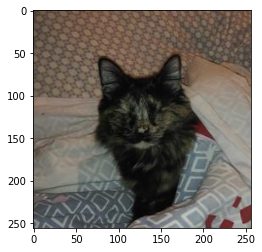

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Мороша


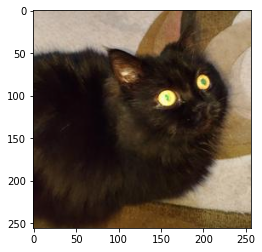

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


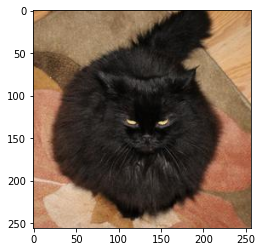

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


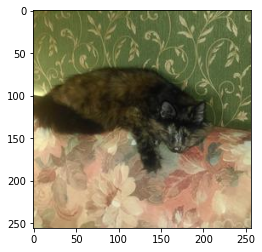

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Лисена


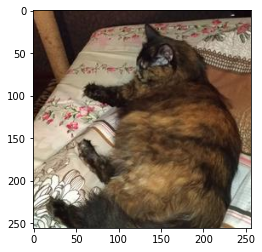

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Лисена


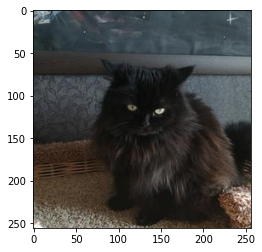

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


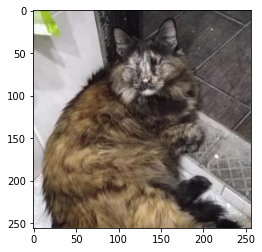

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Лисена
Torchic thinks it is Лисена


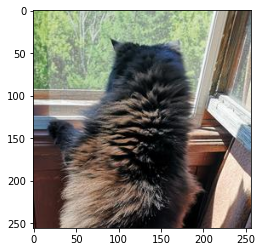

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


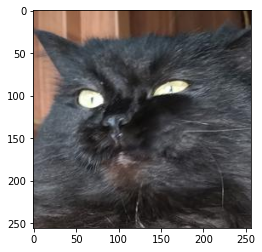

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Dat is Мороша
Torchic thinks it is Мороша


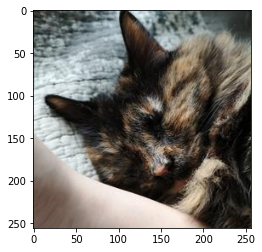

Dat is Лисена
Torchic thinks it is Лисена


In [98]:
classes = {0: 'Лисена', 1: 'Мороша'}

torchic.eval()
for i in range(10):
    matplotlib_imshow(traintest['val'][i][0].permute(1, 2, 0))
    plt.show()
    print(f"Dat is {classes[traintest['val'][i][1]]}")
    ypred = torchic(traintest['val'][i][0].unsqueeze(1).permute(1, 0, 2, 3))
    print(f"Torchic thinks it is {classes[torch.argmax(ypred, dim=-1).item()]}")

Ignite time!

In [91]:
def run(epochs, lr, log_interval):
    model = Torchic()
    device = 'cpu'
    if torch.cuda.is_available():
        device = 'cuda'

    optimizer = opt.Adam(model.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    trainer.logger = setup_logger('trainer')

    val_metrics = {'accuracy': Accuracy(), 'cre': Loss(criterion)}
    evaluator = create_supervised_evaluator(model, metrics=val_metrics, device=device)
    evaluator.logger = setup_logger('evaluator')

    pbar = tqdm(initial=0, leave=False, total=len(train_dataloader), desc=f"ITERATION - loss: {0:.2f}")

    @trainer.on(Events.ITERATION_COMPLETED(every=log_interval))
    def log_training_loss(engine):
        pbar.desc = f'Iteration - loss: {engine.state.output:.2f}'
        pbar.update(log_interval)

    @trainer.on(Events.EPOCH_COMPLETED)
    def log_training_results(engine):
        evaluator.run(val_dataloader)
        metrics = evaluator.state.metrics
        avg_accuracy = metrics['accuracy']
        avg_cre = metrics['cre']
        tqdm.write(
            f"Validation Results - Epoch: {engine.state.epoch} Avg accuracy: {avg_accuracy:.2f} Avg loss: {avg_cre:.2f}"
        )
        pbar.n = pbar.last_print_n = 0

    @trainer.on(Events.EPOCH_COMPLETED | Events.COMPLETED)
    def log_time(engine):
        tqdm.write(f"{trainer.last_event_name.name} took { trainer.state.times[trainer.last_event_name.name]} seconds")

    trainer.run(train_dataloader, max_epochs=epochs)
    pbar.close()

In [99]:
run(epochs=10, lr=0.001, log_interval=10)

ITERATION - loss: 0.00:   0%|          | 0/6 [00:00<?, ?it/s]2022-06-28 11:30:06,580 trainer INFO: Engine run starting with max_epochs=10.
2022-06-28 11:30:09,250 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:09,490 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:09,491 evaluator INFO: Engine run complete. Time taken: 00:00:00
ITERATION - loss: 0.00:   0%|          | 0/6 [00:02<?, ?it/s]2022-06-28 11:30:09,497 trainer INFO: Epoch[1] Complete. Time taken: 00:00:03


Validation Results - Epoch: 1 Avg accuracy: 0.43 Avg loss: 1.45
EPOCH_COMPLETED took 2.6676599979400635 seconds


Iteration - loss: 0.44: 10it [00:04,  2.10it/s]              2022-06-28 11:30:12,172 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:12,406 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:12,407 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.44:   0%|          | 0/6 [00:05<00:02,  2.10it/s]2022-06-28 11:30:12,414 trainer INFO: Epoch[2] Complete. Time taken: 00:00:03


Validation Results - Epoch: 2 Avg accuracy: 0.43 Avg loss: 0.73
EPOCH_COMPLETED took 2.673086166381836 seconds


2022-06-28 11:30:15,056 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:15,285 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:15,286 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.44:   0%|          | 0/6 [00:08<00:02,  2.10it/s]2022-06-28 11:30:15,291 trainer INFO: Epoch[3] Complete. Time taken: 00:00:03


Validation Results - Epoch: 3 Avg accuracy: 0.73 Avg loss: 0.62
EPOCH_COMPLETED took 2.6415746212005615 seconds


Iteration - loss: 0.46: 10it [00:09,  2.06it/s]                      2022-06-28 11:30:17,972 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:18,211 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:18,218 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.46:   0%|          | 0/6 [00:11<00:02,  2.06it/s]2022-06-28 11:30:18,222 trainer INFO: Epoch[4] Complete. Time taken: 00:00:03


Validation Results - Epoch: 4 Avg accuracy: 0.77 Avg loss: 0.58
EPOCH_COMPLETED took 2.680013418197632 seconds


Iteration - loss: 0.15: 10it [00:14,  2.11it/s]                      2022-06-28 11:30:20,882 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:21,140 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:21,141 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.15:   0%|          | 0/6 [00:14<00:02,  2.11it/s]2022-06-28 11:30:21,146 trainer INFO: Epoch[5] Complete. Time taken: 00:00:03


Validation Results - Epoch: 5 Avg accuracy: 0.80 Avg loss: 0.48
EPOCH_COMPLETED took 2.6585731506347656 seconds


2022-06-28 11:30:23,762 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:23,996 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:23,996 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.15:   0%|          | 0/6 [00:17<00:02,  2.11it/s]2022-06-28 11:30:24,003 trainer INFO: Epoch[6] Complete. Time taken: 00:00:03


Validation Results - Epoch: 6 Avg accuracy: 0.77 Avg loss: 0.83
EPOCH_COMPLETED took 2.6146912574768066 seconds


Iteration - loss: 0.02: 10it [00:19,  2.06it/s]                      2022-06-28 11:30:26,739 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:26,974 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:26,975 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.02:   0%|          | 0/6 [00:20<00:02,  2.06it/s]2022-06-28 11:30:26,981 trainer INFO: Epoch[7] Complete. Time taken: 00:00:03


Validation Results - Epoch: 7 Avg accuracy: 0.77 Avg loss: 0.78
EPOCH_COMPLETED took 2.7356064319610596 seconds


2022-06-28 11:30:29,659 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:29,900 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:29,901 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.02:   0%|          | 0/6 [00:23<00:02,  2.06it/s]2022-06-28 11:30:29,906 trainer INFO: Epoch[8] Complete. Time taken: 00:00:03


Validation Results - Epoch: 8 Avg accuracy: 0.77 Avg loss: 0.54
EPOCH_COMPLETED took 2.6786351203918457 seconds


Iteration - loss: 0.00: 10it [00:24,  2.05it/s]                      2022-06-28 11:30:32,606 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:32,840 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:32,841 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.00:   0%|          | 0/6 [00:26<00:02,  2.05it/s]2022-06-28 11:30:32,846 trainer INFO: Epoch[9] Complete. Time taken: 00:00:03


Validation Results - Epoch: 9 Avg accuracy: 0.80 Avg loss: 0.61
EPOCH_COMPLETED took 2.6989784240722656 seconds


Iteration - loss: 0.00: 10it [00:28,  2.09it/s]                      2022-06-28 11:30:35,457 evaluator INFO: Engine run starting with max_epochs=1.
2022-06-28 11:30:35,705 evaluator INFO: Epoch[1] Complete. Time taken: 00:00:00
2022-06-28 11:30:35,706 evaluator INFO: Engine run complete. Time taken: 00:00:00
Iteration - loss: 0.00:   0%|          | 0/6 [00:29<00:02,  2.09it/s]2022-06-28 11:30:35,714 trainer INFO: Engine run complete. Time taken: 00:00:29
                                                                     

Validation Results - Epoch: 10 Avg accuracy: 0.80 Avg loss: 0.68
EPOCH_COMPLETED took 2.609888792037964 seconds
COMPLETED took 29.130746126174927 seconds
